In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
%matplotlib inline
from subprocess import check_output
import cv2
from PIL import Image
import os
from glob import glob


In [23]:
all_images = os.listdir('imgs')

train_images, validation_images = train_test_split(all_images, train_size=0.9, test_size=0.1)

In [24]:
import os
from glob import glob
train_files = glob(os.path.join('imgs', "*.jpg"))
train_ids = [s[len('imgs')+1:-4] for s in train_files]

In [25]:
def get_filename(image_id, image_type):
    check_dir = False
    if "Train" == image_type:
        ext = 'jpg'
        data_path = 'imgs'
        suffix = ''
    elif "Train_mask" in image_type:
        ext = 'png'
        data_path = 'masks'
        suffix = '_mask'
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    if check_dir and not os.path.exists(data_path):
        os.makedirs(data_path)

    return os.path.join(data_path, "{}{}.{}".format(image_id, suffix, ext))

In [26]:
import cv2
from PIL import Image


def get_image_data(image_id, image_type, **kwargs):
    if 'mask' in image_type:
        img = _get_image_data_pil(image_id, image_type, **kwargs)
    else:
        img = _get_image_data_opencv(image_id, image_type, **kwargs)
    return img

def _get_image_data_opencv(image_id, image_type, **kwargs):
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def _get_image_data_pil(image_id, image_type, return_exif_md=False, return_shape_only=False):
    fname = get_filename(image_id, image_type)
    try:
        img_pil = Image.open(fname)
    except Exception as e:
        assert False, "Failed to read image : %s, %s. Error message: %s" % (image_id, image_type, e)

    if return_shape_only:
        return img_pil.size[::-1] + (len(img_pil.getbands()),)

    img = np.asarray(img_pil)
    assert isinstance(img, np.ndarray), "Open image is not an ndarray. Image id/type : %s, %s" % (image_id, image_type)
    if not return_exif_md:
        return img
    else:
        return img, img_pil._getexif()

In [27]:
data_dir = 'imgs'
mask_dir = 'masks'

In [28]:
data_size = len(os.listdir('imgs'))
img_ids = sorted(os.listdir('imgs'))
mask_ids = sorted(os.listdir('masks'))
rnd_ind = list(np.random.choice(data_size,8))
for i in rnd_ind:
    print("image id: '{}' -- Corressponding Mask id '{}'".format(img_ids[i], mask_ids[i]))

image id: 'Image0120.jpg' -- Corressponding Mask id 'Image0120.png'
image id: 'Image0069.jpg' -- Corressponding Mask id 'Image0069.png'
image id: 'Image0010.jpg' -- Corressponding Mask id 'Image0010.png'
image id: 'Image0021.jpg' -- Corressponding Mask id 'Image0021.png'
image id: 'Image0112.jpg' -- Corressponding Mask id 'Image0112.png'
image id: 'Image0275.jpg' -- Corressponding Mask id 'Image0275.png'
image id: 'Image0102.jpg' -- Corressponding Mask id 'Image0102.png'
image id: 'Image0035.jpg' -- Corressponding Mask id 'Image0035.png'


Image Size:  (768, 576)
Mask Size:  (768, 576)


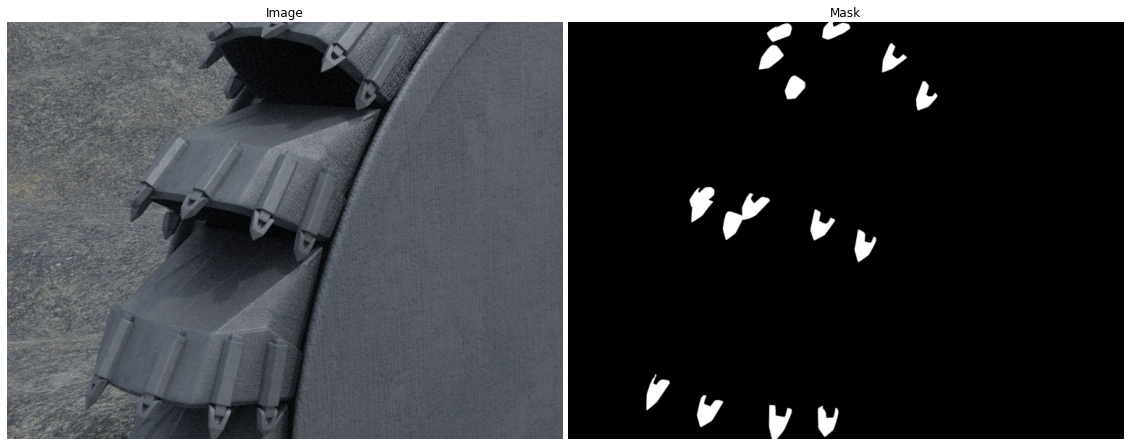

In [29]:
n = 0
img_id = img_ids[n]
mask_id = mask_ids[n]
img = load_img('imgs/' + img_id)
mask = load_img('masks/'+ mask_id)
print("Image Size: ", img.size)
print("Mask Size: ", mask.size)
fig, ax = plt.subplots(1, 2, figsize=(20,20))
fig.subplots_adjust(hspace=.1, wspace=.01)
ax[0].imshow(img)
ax[0].axis('off')
ax[0].title.set_text('Image')
ax[1].imshow(mask)
ax[1].axis('off')
ax[1].title.set_text('Mask')

In [30]:
from sklearn.model_selection import train_test_split
X_train_ids, X_val_ids, y_train_ids, y_val_ids= train_test_split(img_ids, mask_ids,
                                                                 test_size=.1, train_size=.9,
                                                                 random_state=42)
X_train_size = len(X_train_ids)
X_val_size = len(X_val_ids)
print('Training images size:', X_train_size)
print('Validation images size:', X_val_size)

Training images size: 216
Validation images size: 24


In [31]:
_train_ids = list(train_ids)
np.random.shuffle(_train_ids)
_train_ids = _train_ids[:50]
tile_size = (256, 256)
n = 8

m = int(np.ceil(len(_train_ids) * 1.0 / n))
complete_image = np.zeros((m*(tile_size[0]+2), n*(tile_size[1]+2), 3), dtype=np.uint8)

counter = 0
for i in range(m):
    ys = i*(tile_size[1] + 2)
    ye = ys + tile_size[1]
    for j in range(n):
        xs = j*(tile_size[0] + 2)
        xe = xs + tile_size[0]
        if counter == len(_train_ids):
            break
        image_id = _train_ids[counter]; counter+=1
        img = get_image_data(image_id, 'Train')
        img = cv2.resize(img, dsize=tile_size)
        img = cv2.putText(img, image_id, (5,img.shape[0] - 5), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), thickness=2)
        complete_image[ys:ye, xs:xe, :] = img[:,:,:]
    if counter == len(_train_ids):
        break

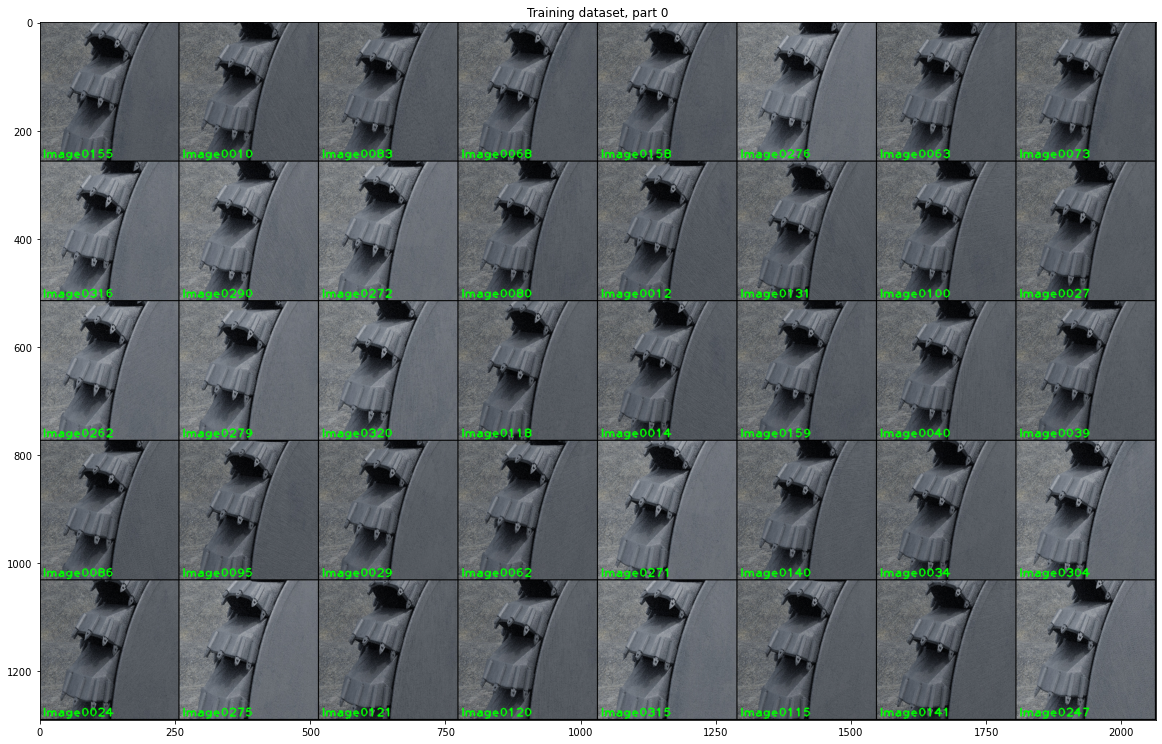

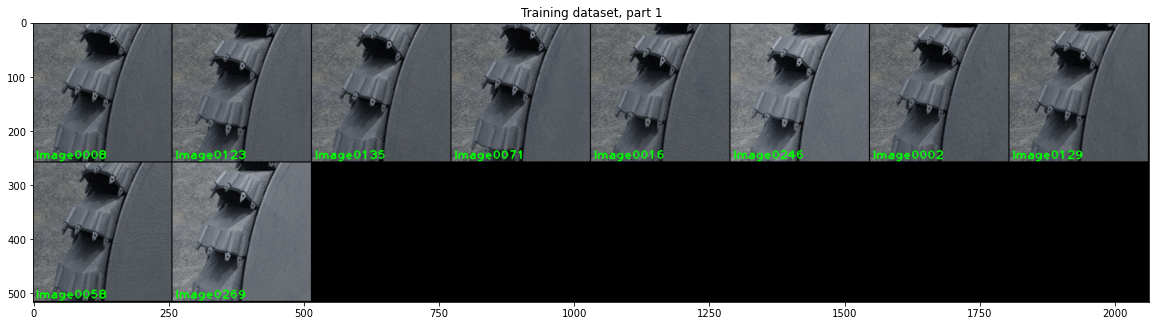

In [32]:
m = complete_image.shape[0] / (tile_size[0] + 2)
k = 5
n = int(np.ceil(m / k))
for i in range(n):
    plt.figure(figsize=(20, 20))
    ys = i*(tile_size[0] + 2)*k
    ye = min((i+1)*(tile_size[0] + 2)*k, complete_image.shape[0])
    plt.imshow(complete_image[ys:ye,:,:])
    plt.title("Training dataset, part %i" % i)

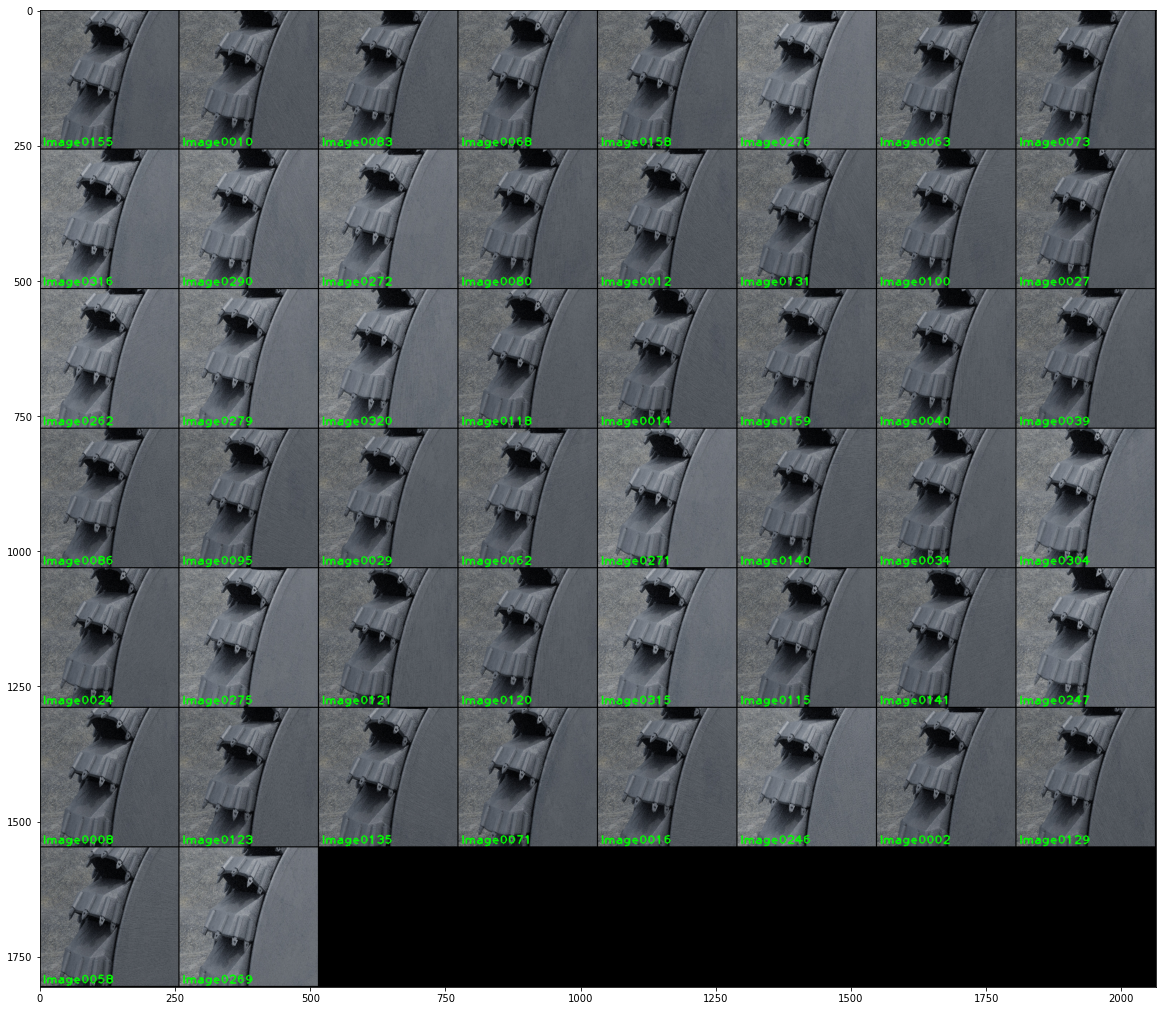

In [34]:
m = complete_image.shape[0] / (tile_size[0] + 2)
k = 8
n = int(np.ceil(m / k))
for i in range(n):
    plt.figure(figsize=(20, 20))
    ys = i*(tile_size[0] + 2)*k
    ye = min((i+1)*(tile_size[0] + 2)*k, complete_image.shape[0])
    plt.imshow(complete_image[ys:ye,:,:])

In [35]:
input_size = [128, 128, 3]
def data_generator(images_path, masks_path, image_ids, mask_ids, batch_size, img_size=input_size):
    data_size = len(image_ids)
    while True:
        rnd_ind = np.random.choice(np.arange(data_size),batch_size)
        imgs = []
        masks = []
        for i in rnd_ind:
            img_id, mask_id = image_ids[i], mask_ids[i]
            img = load_img(images_path + img_id, target_size=img_size) 
            mask = load_img(masks_path + mask_id, target_size=img_size[:-1], color_mode = 'grayscale')
            imgs.append(img_to_array(img))
            masks.append(img_to_array(mask).reshape(img_size[:-1] + [1]))
        yield np.array(imgs, dtype=np.float16) / 255., np.array(masks, dtype=np.float16) / 255.

In [36]:
gen = data_generator('imgs/', 'masks/',
                    X_val_ids, y_val_ids, batch_size=32)

imgs, masks = next(gen)
print('Images batch shape: ', imgs.shape)
print('Masks batch shape: ', imgs.shape)

Images batch shape:  (32, 128, 128, 3)
Masks batch shape:  (32, 128, 128, 3)


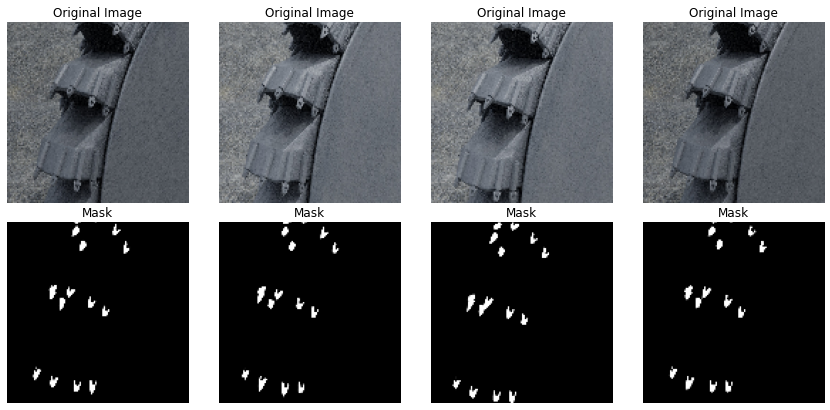

In [37]:
fig, ax = plt.subplots(2, 4, figsize=(15,7))
fig.subplots_adjust(hspace=.1, wspace=.05)
img_samples, mask_samples = imgs[:4].astype(np.float32), masks[:4][:,:,:,0].astype(np.float32)
for i, (img, mask) in enumerate(zip(img_samples, mask_samples)):
    ax[0, i].imshow(img)
    ax[0, i].axis('off')
    ax[0, i].title.set_text('Original Image')
    
    ax[1, i].imshow(mask, cmap='gray')
    ax[1, i].axis('off')
    ax[1, i].title.set_text('Mask')
plt.show() 

In [38]:
import keras
import keras.backend as K

from keras.models import *
from keras.layers import *
from keras.optimizers import *

def Unet(input_shape=(128, 128, 3),
                 num_classes=1):
    inputs = Input(shape=input_shape)

    down1 = Conv2D(64, (3, 3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)

    
    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    return model

model = Unet()

In [39]:
X_train_size


216

In [40]:
batch_size = 40
train_gen = data_generator('imgs/', 'masks/',
                           X_train_ids, y_train_ids, batch_size=batch_size)

In [41]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10585676688979734430
xla_global_id: -1
]


In [ ]:
model.fit(train_gen, steps_per_epoch=10, epochs=20)

Epoch 1/20
10/10 [==============================] - 462s 47s/step - loss: 0.1253 - accuracy: 0.8530
Epoch 2/20
10/10 [==============================] - 465s 47s/step - loss: 0.0310 - accuracy: 0.9688
Epoch 3/20
10/10 [==============================] - 493s 49s/step - loss: 0.0223 - accuracy: 0.9757
Epoch 4/20
10/10 [==============================] - 457s 45s/step - loss: 0.0176 - accuracy: 0.9792
Epoch 5/20
10/10 [==============================] - 478s 48s/step - loss: 0.0162 - accuracy: 0.9804
Epoch 6/20
10/10 [==============================] - 478s 48s/step - loss: 0.0123 - accuracy: 0.9847
Epoch 7/20
10/10 [==============================] - 486s 48s/step - loss: 0.0107 - accuracy: 0.9861
Epoch 8/20
10/10 [==============================] - 478s 48s/step - loss: 0.0092 - accuracy: 0.9878
Epoch 9/20
10/10 [==============================] - 464s 46s/step - loss: 0.0078 - accuracy: 0.9889
Epoch 10/20
10/10 [==============================] - 471s 47s/step - loss: 0.0068 - accuracy: 0.9899

In [ ]:
pred_masks = model.predict(imgs)

In [ ]:
fig, ax = plt.subplots(32, 3, figsize=(20,150))
for i in range(data_size):
    ax[i, 0].imshow(imgs[i].astype(np.float32))
    ax[i, 0].axis('off')
    ax[i, 0].title.set_text('Original Image')
    
    ax[i, 1].imshow(masks[i,:,:,0].astype(np.float32), cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].title.set_text('Real Mask')
    
    ax[i, 2].imshow(pred_masks[i,:,:,0], cmap='gray')
    ax[i, 2].axis('off')
    ax[i, 2].title.set_text('Predicted Mask')
plt.show() 

In [ ]:
import pickle
with open ('model_BTS', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open ('model_BTS', 'rb') as f:
    mp = pickle.load(f)

In [ ]:
new_images = os.listdir('imgs1')

def new_get_image_data(image1_id, image_type, **kwargs):
    img1 = new_get_image_data_opencv(image1_id, image1_type, **kwargs)
    return img1

def new_get_image_data_opencv(image1_id, image1_type, **kwargs):
    fname = get_filename(image1_id, image1_type)
    img1 = cv2.imread(fname)
    assert img1 is not None, "Failed to read image : %s, %s" % (image1_id, image1_type)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    return img1



new_data_dir = 'imgs1'

new_data_size = len(os.listdir('imgs1'))
img1_ids = sorted(os.listdir('imgs1'))
img1_id = img1_ids[n]
img1 = load_img('imgs1/' + img1_id)


input_size = [128, 128, 3]
def new_data_generator(images1_path, image1_ids, batch_size, img1_size=new_input_size):
    new_data_size = len(image1_ids)
    while True:
        rnd_ind1 = np.random.choice(np.arange(new_data_size),batch_size)
        imgs1 = []
     
        for i in rnd_ind1:
            img1_id= img1_ids[i]
            img1 = load_img(images1_path + img1_id, target_size=img1_size) 
  
            imgs1.append(img_to_array(img1))
           
        yield np.array(imgs1, dtype=np.float16) / 255.

new_gen = new_data_generator('imgs1/',
                    img1_ids, batch_size=32)

imgs1 = next(new_gen)
        
pred_masks2 = mp.predict(imgs1)
    
fig, ax = plt.subplots(new_data_size, 3, figsize=(20,150))
for i in range(new_data_size):
    ax[i, 0].imshow(imgs[i].astype(np.float32))
    ax[i, 0].axis('off')
    ax[i, 0].title.set_text('Original Image')
    
    ax[i, 2].imshow(pred_masks2[i,:,:,0], cmap='gray')
    ax[i, 2].axis('off')
    ax[i, 2].title.set_text('Predicted Mask')
plt.show() 